In [1]:
"""
XGBoost multiclassifier for roof materials in Denver, Colorado
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xgboost as xgb
import optuna
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Functions script import
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [2]:
results_dir = os.path.join(homedir, 'OPP/results/xgboost-cv/')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/


In [3]:
# Load the image data

In [4]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/denver_data/planet-data/denver_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/denver/denver_0623_psscene8b_final_norm.tif') # cyverse
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")
del stack_da

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [5]:
# Load the reference data

In [6]:
# Load the training data (footprints)
# ref_fp = os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints_sampled.gpkg')
ref_fp = os.path.join(homedir,'OPP/training/denver/denver_data_reference_footprints_sampled.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,-0.246291,0.373826,0.472331,0.204085,0.080244,2.598158,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,-0.856021,0.632535,1.064584,1.001515,0.569262,0.367447,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,-0.864054,0.813552,0.806408,0.734980,0.218044,-0.683204,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,-0.735984,0.305262,0.856115,0.508690,0.070037,0.680645,"POLYGON ((333608.130 4306267.691, 333607.957 4..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,-0.418819,0.516599,0.897064,0.448048,0.185206,-0.394834,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [7]:
print(ref['class_code'].value_counts())

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64


In [8]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])

# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))

print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [9]:
# Create a holdout sample for model evaluation later on

In [10]:
# Create the holdout data (independent from model training in CV)
holdout_fraction = 0.20 # excluding 20% of the data for holdout/independent testing
train_df, holdout_df, _ = split_training_data(ref, ts=holdout_fraction, vs=None) # no validation needed yet

print("Training set class distribution:\n", train_df[['class_code','code']].value_counts())
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Training set class distribution:
 class_code  code
CS          0       29706
ME          1       29491
SL          2       12213
UR          3        1023
WS          5         921
TL          4         739
SH          6         626
Name: count, dtype: int64
Holdout set class distribution:
 class_code  code
CS          0       7427
ME          1       7373
SL          2       3054
UR          3        256
WS          5        231
TL          4        185
SH          6        157
Name: count, dtype: int64


In [11]:
# Parameter tuning using Optuna

In [12]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(train_df['code'])),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1e-2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 101, 1001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1.0),
        'random_state': 44
    }

    # Stratified 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    
    f1_scores = [] # to store the validation F1 for each fold
    
    for train_idx, val_idx in skf.split(train_df, train_df['class_code']):
        # Extract the train and validation sets
        fold_train = train_df.iloc[train_idx]
        fold_val = train_df.iloc[val_idx]

        # Undersample majority class in training set only
        fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')

        # Calculate the class weights
        val_counts = fold_train_bal['code'].value_counts()
        total_samples = sum(val_counts)
        class_weights = np.array([total_samples / count for count in val_counts])
        class_weights_n = class_weights / class_weights.sum() # normalize the weights
        class_weights_n = {cls: weight for cls, weight in zip(np.unique(fold_train_bal['code']), class_weights)}

        # Define our train/validation sets
        X_train = fold_train_bal[band_names].astype(float)
        y_train = fold_train_bal['code'].astype(int)
        X_val = fold_val[band_names].astype(float)
        y_val = fold_val['code'].astype(int)
        
        del fold_train, fold_val, fold_train_bal # clear up space

        # Fit the XGBoost with params
        xgb_model = xgb.XGBClassifier(n_jobs=1, **params) # avoid over-using CPU resources
        xgb_model.fit(
            X_train, y_train,
            sample_weight=y_train.map(class_weights_n).values,
            verbose=False
        )

        # Evaluate F1-score on the validation set
        y_pred = xgb_model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

        del y_pred, f1, X_train, y_train, X_val, y_val, xgb_model

    # Calculate mean metrics across folds
    f1_ = np.mean(f1_scores)

    del f1_scores
    gc.collect()

    return f1_  # Optuna will maximize this score

print("Optuna function ready to go !!!")

Optuna function ready to go !!!


In [13]:
t0 = time.time()

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Implement the optuna objective study
study = optuna.create_study(direction='maximize', study_name='denver_xgboost_tuning') # maximize the scoring criteria
study.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)  # Adjust the number of trials as needed
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters found: {best_params}")
# Save the Optuna study for later analysis
study.trials_dataframe().to_csv(os.path.join(results_dir, 'denver-xgboost-cv_optuna_trials.csv'), index=False)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time for 100 trials: {t2:.2f} minutes.")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



  0%|          | 0/200 [00:00<?, ?it/s]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Best hyperparameters found: {'learning_rate': 0.002185884764883822, 'max_depth': 12, 'n_estimators': 837, 'min_child_weight': 2, 'subsample': 0.5014281326674929, 'colsample_bytree': 0.9226235922462854, 'gamma': 0.8462080004717595}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Total elapsed time for 100 trials: 13.77 minutes.


In [14]:
best_params

{'learning_rate': 0.002185884764883822,
 'max_depth': 12,
 'n_estimators': 837,
 'min_child_weight': 2,
 'subsample': 0.5014281326674929,
 'colsample_bytree': 0.9226235922462854,
 'gamma': 0.8462080004717595}

In [15]:
# Model run w/ best parameters

In [16]:
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          0       7427
ME          1       7373
SL          2       3054
UR          3        256
WS          5        231
TL          4        185
SH          6        157
Name: count, dtype: int64


In [52]:
t0 = time.time()

# Set up the stratified K-fold CV
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=44)

# Loop the folds
fold_idx = 1
# Define dataframes to store results for this feature set
all_fold_results = []  # to store the true/predicted
all_metric_results = [] # to store model performance across folds/n_estimators
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['class_code'])):
    t00 = time.time()
    print(f"Processing fold {fold_idx + 1}/{n_folds}...")

    # Get the train and validation splits for this fold
    fold_train = train_df.iloc[train_idx]
    fold_val = train_df.iloc[val_idx]

    # Apply random undersampling to the training data within this fold
    fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')

    print(f"Train class distribution (fold {fold_idx + 1}):\n", fold_train_bal['code'].value_counts().to_dict())
    print(f"Validation class distribution (fold {fold_idx + 1}):\n", fold_val['code'].value_counts().to_dict())

    # Calculate the class weights
    val_counts = fold_train_bal['code'].value_counts()
    total_samples = sum(val_counts)
    class_weights = np.array([total_samples / count for count in val_counts])
    class_weights_n = class_weights / class_weights.sum() # normalize the weights
    class_weights_n = {cls: weight for cls, weight in zip(np.unique(fold_train_bal['code']), class_weights)}

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(fold_train_bal['code'])),
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
        early_stopping_rounds=100, # stop if no improvement
        random_state=44
    )

    #################
    # Fit the model #

    # Define train/validation/holdout sets
    X_train = fold_train_bal[band_names].astype(float)
    y_train = fold_train_bal['code'].astype(int)
    X_val = fold_val[band_names].astype(float)
    y_val = fold_val['code'].astype(int)

    # Define our evaluation sets
    eval_set = [(X_train, y_train), (X_val, y_val)]

    xgb_model.fit(
        X_train, y_train,
        eval_set=eval_set,  # Specify train/validation/holdout sets for evaluation
        sample_weight=y_train.map(class_weights_n).values,
        verbose=False
    )
    
    # Retrieve the evaluation metrics for the fold
    eval_results = xgb_model.evals_result()
    # Store the performance metrics
    metrics_df = pd.DataFrame({
        'fold_idx': fold_idx + 1,
        'n_estimators': range(len(eval_results['validation_1']['mlogloss'])),
        'train_mlogloss': eval_results['validation_0']['mlogloss'],
        'val_mlogloss': eval_results['validation_1']['mlogloss'],
        'train_auc': eval_results['validation_0']['auc'],
        'val_auc': eval_results['validation_1']['auc'],
        'train_merror': eval_results['validation_0']['merror'],
        'val_merror': eval_results['validation_1']['merror']
    })
    all_metric_results.append(metrics_df)

    #####################################
    # Make prediction on validation set #
    
    # Predict on the validation set
    y_pred = xgb_model.predict(X_val)
    
    # Calculate the validation  accuracy and f1-score (weighted)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    acc_val = accuracy_score(y_val, y_pred)

    print(f"\tFold [{fold_idx}] accuracy: {acc_val:.3f};\n\tF1-score: {f1_val:.3f};")
    
    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'fold_idx': fold_idx + 1,
        'val_f1': [f1_val] * len(y_val),
        'val_acc': [acc_val] * len(y_val),
        'val_labs': y_val,
        'val_preds': y_pred,
    })
    
    # Concatenate with the results data frame
    results.append(fold_results)

    # Save the model for further evaluation
    model_fn = f"denver-xgb_fold{fold_idx + 1}.model"
    xgb_model.save_model(os.path.join(results_dir, model_fn))

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")

    del X_train, y_train, X_val, y_val, y_pred, val_counts, total_samples, class_weights, fold_train # clean up some
    gc.collect()

    print("\n~~~~~~~~~~\n")

# Save the metrics across folds
metrics_df = pd.concat(all_metric_results, ignore_index=True)
metrics_df.to_csv(os.path.join(results_dir, 'denver-xgboost-cv_fold_metrics.csv'), index=False)

# Save the fold results dataframe
results_df = pd.concat(results, ignore_index=True)
results_df.to_csv(os.path.join(results_dir, 'denver-xgboost-cv_fold_results.csv'))

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Total elapsed time: 3.80 minutes.


In [53]:
results_df.head()

,fold_idx,val_f1,val_acc,val_labs,val_preds
0,1,0.596674,0.557347,0,2
1,1,0.596674,0.557347,0,2
2,1,0.596674,0.557347,0,0
3,1,0.596674,0.557347,0,0
4,1,0.596674,0.557347,0,2


In [ ]:
# Make predictions on the holdout set

In [62]:
all_preds = [] # To store the prediction data frame across folds
n_classes = len(code_mapping.keys())
for fold_idx in range(1, n_folds + 1):
    print(f"Making predictions with model from fold {fold_idx}")

    # Load the trained model for the current fold
    model_fp = os.path.join(results_dir, f'denver-xgb_fold{fold_idx}.model')
    print(f"Loading model from path: {model_fp}")
    
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(fold_train_bal['code'])),
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
        early_stopping_rounds=100, # stop if no improvement
        random_state=44
    )
    
    xgb_model.load_model(model_fp)

    # Gather the holdout data
    X_test = holdout_df[band_names].astype(float)
    y_test = holdout_df['code'].astype(int)

    # Make predictions on the holdout data
    y_test_pred = xgb_model.predict(X_test)  # Get predicted class
    y_pred_probs = xgb_model.predict_proba(X_test) # Get predicted probabilities

    # Store true and predicted labels, and map to class codes
    fold_df = pd.DataFrame({
        'fold_idx': fold_idx,
        'true_code': y_test,  # Assuming y_test is already defined
        'pred_code': y_test_pred,
        'true_label': [code_mapping[code] for code in y_test],
        'pred_label': [code_mapping[pred] for pred in y_test_pred]
    })

    # Add predicted probabilities for each class as separate columns
    for class_idx in range(n_classes):
        label = code_mapping[class_idx]
        fold_df[f"{label}"] = y_pred_probs[:, class_idx]

    # Append the results for the current fold
    all_preds.append(fold_df)

# Concatenate all folds' results into a single DataFrame
preds_df = pd.concat(all_preds, ignore_index=True)

Making predictions with model from fold 1
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold1.model
Making predictions with model from fold 2
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold2.model
Making predictions with model from fold 3
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold3.model
Making predictions with model from fold 4
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold4.model
Making predictions with model from fold 5
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/dc-xgb_fold5.model


In [63]:
preds_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,CS,ME,SL,UR,TL,WS,SH
0,1,0,0,CS,CS,0.244081,0.102749,0.128716,0.092079,0.120637,0.177926,0.133813
1,1,0,0,CS,CS,0.198814,0.148781,0.156685,0.091495,0.142961,0.117193,0.144072
2,1,0,4,CS,TL,0.158815,0.099323,0.163106,0.091547,0.227949,0.129524,0.129736
3,1,0,0,CS,CS,0.260729,0.089806,0.161800,0.086586,0.116693,0.151523,0.132863
4,1,0,2,CS,SL,0.136481,0.087622,0.288528,0.086799,0.141159,0.139450,0.119961


In [69]:
out_file = os.path.join(results_dir,'denver-xgboost-cv_fold_pred_probs.csv')
preds_df.to_csv(out_file)

In [19]:
# Plot the 'mlogloss' across folds

In [76]:
print(metrics_df.head())
fold = metrics_df[metrics_df['fold'] == 3]
print(fold['n_estimators'].max())

   fold  n_estimators  train_mlogloss  val_mlogloss  train_auc   val_auc  \
0     1             0        1.943623      1.944395   0.827490  0.757162   
1     1             1        1.941118      1.942678   0.878099  0.790337   
2     1             2        1.938563      1.940931   0.903501  0.806609   
3     1             3        1.936145      1.939283   0.917130  0.814626   
4     1             4        1.933674      1.937698   0.927466  0.819809   

   train_merror  val_merror  
0      0.495572    0.636777  
1      0.406810    0.578627  
2      0.349341    0.544098  
3      0.313226    0.525562  
4      0.293545    0.515190  
450


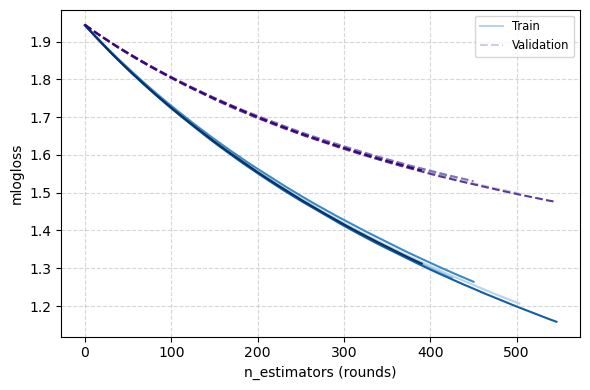

In [77]:
plt.figure(figsize=(6, 4))

# Colors for folds
colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Purples(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(1, n_folds + 1)):
    # Extract the data for this fold
    fold_data = metrics_df[metrics_df['fold'] == fold_idx]

    # Extract mlogloss values
    mlogloss_train = fold_data['train_mlogloss']
    mlogloss_val = fold_data['val_mlogloss']
    n_estimators = fold_data['n_estimators']  # n_estimators column is same for each fold

    # Plot the mlogloss across n_estimators
    plt.plot(n_estimators, mlogloss_train, color=colors_train[idx], linestyle='-', label='Train' if idx == 0 else "")
    plt.plot(n_estimators, mlogloss_val, color=colors_val[idx], linestyle='--', label='Validation' if idx == 0 else "")

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('mlogloss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears only once
plt.legend(loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_mlogloss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [21]:
# Multiclass error across folds

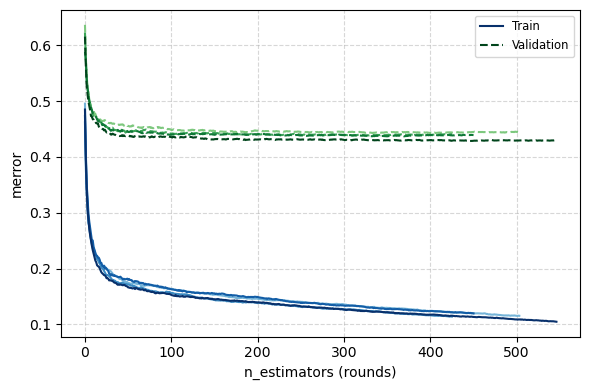

In [81]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = metrics_df[metrics_df['fold'] == fold_idx]
          
    merror_train = fold_data['train_merror'] 
    merror_val = fold_data['val_merror']      
    n_estimators = fold_data['n_estimators']
    
    # Plot the mlogloss across epochs
    plt.plot(n_estimators, merror_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(n_estimators, merror_val, color=colors_val[idx], linestyle='--', label=f'Validation')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('merror')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_merror.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [23]:
# Model AUC across folds

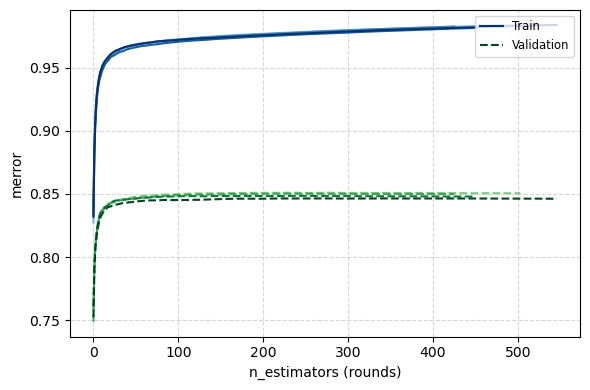

In [83]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = metrics_df[metrics_df['fold'] == fold_idx]
          
    auc_train = fold_data['train_auc']
    auc_val = fold_data['val_auc']     
    n_estimators = fold_data['n_estimators']

    # Plot the mlogloss across epochs
    plt.plot(n_estimators, auc_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(n_estimators, auc_val, color=colors_val[idx], linestyle='--', label=f'Validation')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('merror')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_auc.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

,fold_idx,true_code,pred_code,true_label,pred_label,CS,ME,SL,UR,TL,WS,SH
0,1,0,0,CS,CS,0.244081,0.102749,0.128716,0.092079,0.120637,0.177926,0.133813
1,1,0,0,CS,CS,0.198814,0.148781,0.156685,0.091495,0.142961,0.117193,0.144072
2,1,0,4,CS,TL,0.158815,0.099323,0.163106,0.091547,0.227949,0.129524,0.129736
3,1,0,0,CS,CS,0.260729,0.089806,0.161800,0.086586,0.116693,0.151523,0.132863
4,1,0,2,CS,SL,0.136481,0.087622,0.288528,0.086799,0.141159,0.139450,0.119961


In [25]:
# Bar chart of correct against true

In [84]:
code_mapping = dict(zip(ref['code'], ref['class_code']))
print(code_mapping)

{0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 4: 'TL', 5: 'WS', 6: 'SH'}


In [87]:
preds_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,CS,ME,SL,UR,TL,WS,SH
0,1,0,0,CS,CS,0.244081,0.102749,0.128716,0.092079,0.120637,0.177926,0.133813
1,1,0,0,CS,CS,0.198814,0.148781,0.156685,0.091495,0.142961,0.117193,0.144072
2,1,0,4,CS,TL,0.158815,0.099323,0.163106,0.091547,0.227949,0.129524,0.129736
3,1,0,0,CS,CS,0.260729,0.089806,0.161800,0.086586,0.116693,0.151523,0.132863
4,1,0,2,CS,SL,0.136481,0.087622,0.288528,0.086799,0.141159,0.139450,0.119961


In [89]:
# Count the number of correct
preds_df['correct'] = preds_df['true_label'] == preds_df['pred_label']
correct_df = preds_df.groupby(['fold_idx', 'true_label']).agg(correct_count=('correct', 'sum')).reset_index()
correct_df = correct_df.groupby('true_label')['correct_count'].agg(['mean', 'std']).reset_index()
# Get total counts of true labels
total_counts = preds_df.groupby(['fold_idx', 'true_label']).size().reset_index(name='total_count')
total_counts_mn = total_counts.groupby('true_label')['total_count'].mean().reset_index()
# Merge back to data frame
correct_df = correct_df.merge(total_counts_mn, on='true_label', how='left')
correct_df.head()

,true_label,mean,std,total_count
0,CS,3807.4,66.923837,7427.0
1,ME,4779.4,110.151260,7373.0
2,SH,2.8,1.095445,157.0
3,SL,1740.8,26.752570,3054.0
4,TL,49.0,3.535534,185.0


In [29]:
# Generate the classification reports

In [94]:
all_reports = [] # to store the classification reports for each fold
class_codes = list(preds_df['true_label'].unique())
print(class_codes)

# Iterate over the folds
for fold_idx in results_df['fold_idx'].unique():
    print(f"Create CR for fold [{fold_idx}]")

    fold_preds_df = preds_df[preds_df['fold_idx'] == fold_idx]

    print(fold_preds_df.correct.value_counts())
    
    # Gather the true and predicted labels
    true_labs_fold = fold_preds_df['true_label']
    pred_labs_fold = fold_preds_df['pred_label']

    # Generate the classification report
    cr_fold = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
    cr_fold['fold_idx'] = fold_idx
    cr_fold = cr_fold.reset_index().rename(columns={'index': 'class_code'})
    cr_fold = cr_fold[cr_fold['class_code'].isin(class_codes)] # keep only the per class metrics (i.e., not the weighted average)
    all_reports.append(cr_fold)

# Combine the reports
cr_df = pd.concat(all_reports, axis=0)

# Save the report as a CSV
cr_df.to_csv(os.path.join(results_dir, 'denver-xgboost-cv_classification_reports.csv'))
print(cr_df)

['CS', 'ME', 'SL', 'UR', 'TL', 'WS', 'SH']
Create CR for fold [1]
correct
True     10386
False     8297
Name: count, dtype: int64
Create CR for fold [2]
correct
True     10566
False     8117
Name: count, dtype: int64
Create CR for fold [3]
correct
True     10483
False     8200
Name: count, dtype: int64
Create CR for fold [4]
correct
True     10657
False     8026
Name: count, dtype: int64
Create CR for fold [5]
correct
True     10423
False     8260
Name: count, dtype: int64
  class_code  precision    recall  f1-score  support  fold_idx
0         CS   0.730381  0.497509  0.591863   7427.0         1
1         ME   0.795618  0.645192  0.712552   7373.0         1
2         SH   0.027273  0.019108  0.022472    157.0         1
3         SL   0.382872  0.575311  0.459767   3054.0         1
4         TL   0.114078  0.254054  0.157454    185.0         1
5         UR   0.061818  0.398438  0.107030    256.0         1
6         WS   0.028281  0.108225  0.044843    231.0         1
0         CS   0.7

In [95]:
# Calculate the mean metrics across all folds
cr_summary = cr_df[['class_code', 'precision', 'recall', 'f1-score']].groupby('class_code').agg(['mean', 'std']).reset_index()
cr_summary.columns = ['class_code', 'precision', 'precision_sd', 
                      'recall', 'recall_sd', 
                      'f1-score', 'f1-score_sd']
cr_summary

,class_code,precision,precision_sd,recall,recall_sd,f1-score,f1-score_sd
0,CS,0.728758,0.001284,0.512643,0.009011,0.601848,0.005992
1,ME,0.795915,0.002012,0.648230,0.014940,0.714454,0.009470
2,SH,0.031521,0.014920,0.017834,0.006977,0.022599,0.009288
3,SL,0.385012,0.003925,0.570007,0.008760,0.459581,0.005213
4,TL,0.113710,0.010595,0.264865,0.019111,0.158958,0.012567
5,UR,0.059182,0.002771,0.382812,0.018936,0.102469,0.004184
6,WS,0.034506,0.004246,0.110823,0.005808,0.052550,0.005451


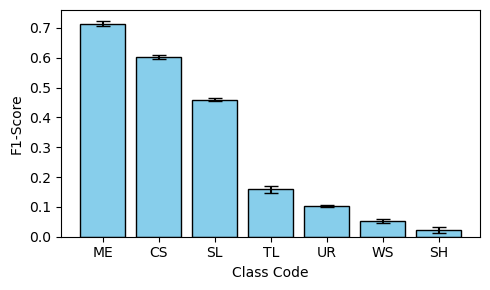

In [96]:
cr_summary = cr_summary.sort_values(by='f1-score', ascending=False)

plt.figure(figsize=(5, 3))
plt.bar(cr_summary['class_code'], cr_summary['f1-score'], 
        yerr=cr_summary['f1-score_sd'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('F1-Score')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_mean_f1-score_bar.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [33]:
# Identify the best model from the folds

In [99]:
f1_scores_wt = [] # to store the weighted f1-scores
for fold_idx in cr_df['fold_idx'].unique():
    # Filter data for the current fold
    fold_data = cr_df[cr_df['fold_idx'] == fold_idx]
    
    # Calculate the weighted F1-score for this fold
    total_support = fold_data['support'].sum()
    weighted_f1 = (fold_data['f1-score'] * fold_data['support']).sum() / total_support
    
    # Append the results
    f1_scores_wt.append({'fold_idx': fold_idx, 'weighted_f1_score': weighted_f1})

# Convert to a DataFrame
f1_scores_wt_df = pd.DataFrame(f1_scores_wt)

# Identify the best-performing fold
best_fold = f1_scores_wt_df.loc[f1_scores_wt_df['weighted_f1_score'].idxmax()]
print(f"Best performing fold is Fold {int(best_fold['fold_idx'])} with a weighted F1-score of {best_fold['weighted_f1_score']:.4f}")

Best performing fold is Fold 4 with a weighted F1-score of 0.6054


In [100]:
best_fold_df = preds_df[preds_df['fold_idx'] == int(best_fold['fold_idx'])]
best_fold_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,CS,ME,SL,UR,TL,WS,SH,correct
56049,4,0,0,CS,CS,0.218703,0.103529,0.134494,0.087586,0.152424,0.180344,0.122920,True
56050,4,0,0,CS,CS,0.186515,0.162161,0.150990,0.091126,0.138105,0.124428,0.146676,True
56051,4,0,0,CS,CS,0.227288,0.101082,0.143820,0.089427,0.178861,0.139293,0.120228,True
56052,4,0,0,CS,CS,0.265648,0.090951,0.177346,0.086048,0.099852,0.147098,0.133056,True
56053,4,0,2,CS,SL,0.136490,0.083512,0.276853,0.082903,0.137507,0.156474,0.126261,False


In [101]:
# Gather the report for the best model

# Gather the true and predicted labels
true_labs_fold = best_fold_df['true_code']
pred_labs_fold = best_fold_df['pred_code']

# Generate the classification report
cr_best = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
print(cr_best)

              precision    recall  f1-score       support
0              0.727583  0.516763  0.604314   7427.000000
1              0.796392  0.670555  0.728076   7373.000000
2              0.381144  0.558612  0.453121   3054.000000
3              0.061427  0.363281  0.105085    256.000000
4              0.108932  0.270270  0.155280    185.000000
5              0.037369  0.108225  0.055556    231.000000
6              0.012195  0.006369  0.008368    157.000000
accuracy       0.570412  0.570412  0.570412      0.570412
macro avg      0.303577  0.356297  0.301400  18683.000000
weighted avg   0.668308  0.570412  0.605361  18683.000000


In [37]:
# Generate confusion matrices

In [102]:
class_names = list(code_mapping.values())
print(class_names)

['CS', 'ME', 'SL', 'UR', 'TL', 'WS', 'SH']


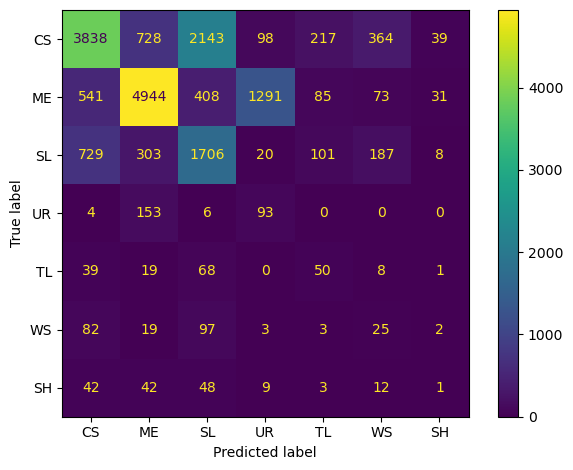

In [105]:
# For the best performing model (Fold 2)
cm_best = confusion_matrix(
    best_fold_df['true_label'], 
    best_fold_df['pred_label'], 
    labels=class_names)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=class_names)
disp.plot(cmap='viridis')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_confusion_matrix_bestFold.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

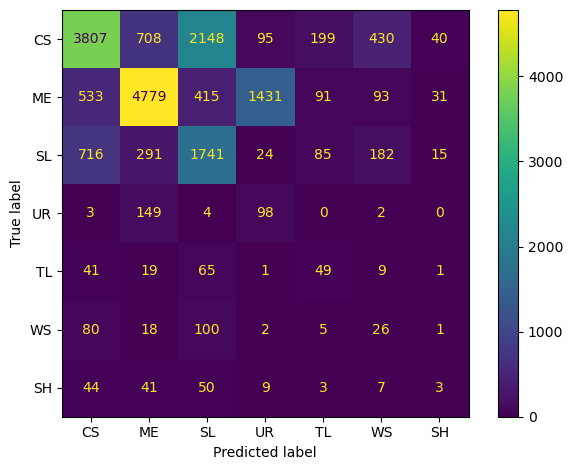

In [109]:
average_cm = np.zeros((len(class_names), len(class_names)))

# Iterate through each fold and accumulate the confusion matrix
for fold_idx in preds_df['fold_idx'].unique():
    fold_preds = preds_df[preds_df['fold_idx'] == fold_idx]
    cm_fold = confusion_matrix(
        fold_preds['true_label'], 
        fold_preds['pred_label'], 
        labels=class_names
    )
    average_cm += cm_fold

# Divide by the number of folds to get the average
average_cm /= len(preds_df['fold_idx'].unique())
average_cm = np.rint(average_cm).astype(int)

# Plot the confusion matrix
disp_avg = ConfusionMatrixDisplay(confusion_matrix=average_cm, display_labels=class_names)
disp_avg.plot(cmap='viridis', values_format='d')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_confusion_matrix_average.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

In [110]:
gc.collect()

42149